# <font color='#009e74'>**Short tutorial "Semi-supervised Generative Adversarial Network"**

Pharmacophore-based search was done in three small molecule databases Zinc15, ChemSpace и ChemDiv using web-server [Pharmit](https://pharmit.csb.pitt.edu/) the dataset of molecules were obtained in _sdf_ format. Then the duplicates were deleted by getting a unique InChI key for all molecules by rdkit module Chem.


In [1]:
# the example of a code to reduce duplicates

# df['INCHI'] = df['Mol'].apply(lambda x: Chem.MolToInchiKey(x))
# df = df.drop_duplicates(subset=['INCHI'], keep='first')
# df['SMILES'] = df['Mol'].apply(lambda x: Chem.MolToSmiles(x))

After obtaining SMILES, they were sent to [JTVAE](https://arxiv.org/abs/1802.04364) [pretrained model](https://github.com/wengong-jin/icml18-jtnn/tree/master/molvae/MPNVAE-h450-L56-d3-beta0.001) encoder and the embeddings were gotten and saved in the SGAN/dataset/lat_vecs_dataset.t file as tensors.

Also for all molecules the molecular docking with the KasA target protein was perfomed by using the QuickVina 2 scoring function. The results are stored in SGAN/dataset/vina_dataset.csv.

In [2]:
#@title <b><font>1. Download the [project folder](https://drive.google.com/drive/folders/1ZveMaVIv3XBMT5a3__vCFZcD4MaFptCP?usp=drive_link) to Google Colab runtime session.</font></b>

%%bash
if [ ! -d rawdata ]; then
  gdown --folder https://drive.google.com/drive/folders/1ZveMaVIv3XBMT5a3__vCFZcD4MaFptCP?usp=drive_link &> /dev/null
fi

*But it is recommended to download files to your personal Google Drive, mount it and work with the copies of files directly. Cause all the data you created or attached to the runtimes of Colab session will be lost when you lose the connection.*

### **2. The whole dataset preprocessing**

In [3]:
# import needed libraries
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import datetime

import pandas as pd
import numpy as np

* Downloading the embeddings and molecular docking results for them.

In [4]:
dataset_path = "SGAN/dataset"

In [5]:
lat_vecs_dataset = torch.load(dataset_path + '/lat_vecs_dataset.t')
lat_vecs_dataset.requires_grad_(False) # we do not need to update this tensor during the model training
lvecs = lat_vecs_dataset.reshape(lat_vecs_dataset.shape[0], 56) # 2*28 - junction tree and graph representations for each embedding
                                                              # reshaping to one vector with length 56
lvecs.shape

torch.Size([58815, 56])

In [6]:
# QuickVina 2 data for the molecules
vina_dataset_df = pd.read_csv(dataset_path + '/vina_dataset.csv')
vina_dataset_df['idx'] = range(0, len(vina_dataset_df))
vina_values = torch.tensor(vina_dataset_df["E_vina, kcal/mol"]).float() # convert to tensor
vina_dataset_df.head(2)

,"E_vina, kcal/mol",idx
0,-9.5,0
1,-9.0,1


Let's see the graphs of the **sorted** and **initial** datasets

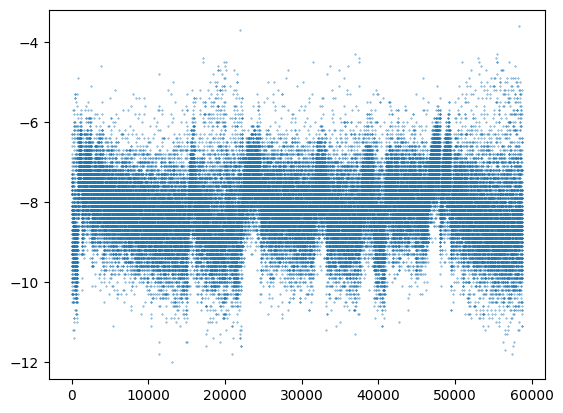

In [7]:
# initial
plt.scatter(np.arange(lvecs.shape[0]), vina_values.numpy(), s=0.1)

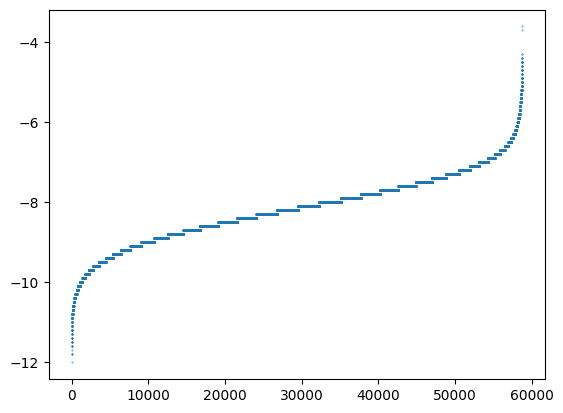

In [8]:
sorted_vina_dataset_df = vina_dataset_df.sort_values(by='E_vina, kcal/mol')
sorted_idx = list(sorted_vina_dataset_df['idx'])

sorted_lvecs = lvecs[sorted_idx]
sorted_vina_values = vina_values[sorted_idx]

# sorted
plt.scatter(np.arange(sorted_lvecs.shape[0]), sorted_vina_values.numpy(), s=0.1)

### **3. Splitting the data into training and validation datasets**

In [9]:
# 80 % of the data is training dataset and 20 % is validation
train_dataset, valid_dataset = lvecs[:int(0.8*len(lvecs))], lvecs[int(0.8*len(lvecs)):]
train_vina, valid_vina = vina_values[:int(0.8*len(lvecs))], vina_values[int(0.8*len(lvecs)):]

In [10]:
print(f"Size of trainig data: {train_dataset.shape[0]}.")
print(f"Size of validation data: {valid_dataset.shape[0]}.")

Size of trainig data: 47052.
Size of validation data: 11763.


In [11]:
# prepare data to SGAN training
# set batch size = 64 and shuffle = True

data = TensorDataset(train_dataset, (train_vina < -8.2).float()) # the second value is the energy class
dataloader = DataLoader(dataset=data, batch_size=64, shuffle=True, drop_last=True) # drop_last = true ignores the last batch

* The example of the dataloader content:

In [12]:
next(iter(dataloader))

[tensor([[ 1.2387, -5.4740,  3.2750,  ..., -0.2456, -0.1709,  0.4468],
         [-1.1217, -8.0373, -9.1590,  ...,  0.3251, -0.2663, -0.1922],
         [ 0.4149, -0.1468,  0.2266,  ..., -0.1619,  0.1213,  0.2759],
         ...,
         [ 2.6988, -4.8375,  2.0680,  ..., -0.4316, -0.0622,  0.1850],
         [-1.2850, -5.4947, -2.9010,  ...,  0.1851, -0.0326,  0.7182],
         [ 2.5475, -0.3882, -4.0070,  ..., -0.2148,  0.1065,  0.3328]]),
 tensor([1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
         0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 1., 0.])]

# <font color='#009e74'>**SGAN Model**

In [13]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from scipy.stats import norm, uniform
from tqdm.notebook import tqdm

from IPython.display import clear_output

noise_size = 256 # two global variables that will be used further in the notebook
lat_vect_size = 56

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_size,  512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),

            nn.Linear(512,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),

            nn.Linear(1024,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),

            nn.Linear(1024,  2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.1),

            nn.Linear(2048,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),

            nn.Linear(1024,  512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),

            nn.Linear(512,  lat_vect_size),
            nn.BatchNorm1d(lat_vect_size),
            nn.LeakyReLU(0.1),
        )

    def forward(self, X):
        return self.net(X)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fe = nn.Sequential(
            nn.Linear(lat_vect_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(512,  256),
            nn.BatchNorm1d(256),
        )
        self.real = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
        self.clss = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )

    def forward(self, X):
        fs =  self.fe(X)
        return self.real(fs), self.clss(fs)

## **SGAN training function**

Make GPU available:
1. in the right upper corner press "down arrow" button
2. select “Change runtime type”
3. choose option “T4 GPU” instead of CPU

In [16]:
def GAN_training(generator, discriminator, num_epochs, dataloader=dataloader, generator_train_prob=0.3, folder_name = 'models'):
    gen = generator.to(device)
    disc = discriminator.to(device)

    gen_optim = Adam(gen.parameters(), lr=1e-3)
    disc_optim = Adam(disc.parameters(), lr=1e-3)
    gen_scheduler = CosineAnnealingLR(gen_optim, num_epochs) # the method to optimize the learning rate
    disc_scheduler = CosineAnnealingLR(disc_optim, num_epochs)
    rv_n = norm() # A normal continuous random variable

    gen_epoch_loss = []
    disc_epoch_loss = []
    for ep in range(num_epochs):
        gen.train()
        disc.train()
        progress_bar = tqdm(dataloader, desc=f"Train epoch {ep}")
        gen_losses = []
        disc_losses = []
        for X, y in progress_bar:
            fake_noise = torch.tensor(rv_n.rvs(size=(X.shape[0], noise_size))).float().to(device)
            fake_vectors = gen(fake_noise)

            real_vectors = X.float().to(device) # X - latent vectors
            real_labels = y.float().to(device)  # y - vina class

            # prob - the probability of reality
            # clss - the probability of the Low (< 8.2 kcal/mol) binding free energy class
            prob, clss = disc(torch.cat([real_vectors, fake_vectors], dim=0))
            real_vecs_len = real_vectors.shape[0]
            real_prob = prob[:real_vecs_len]
            real_clss = clss[:real_vecs_len]
            fake_prob = prob[real_vecs_len:]
            fake_clss = clss[real_vecs_len:]

            if uniform.rvs() < generator_train_prob:
                loss = 0
                loss += nn.functional.binary_cross_entropy(fake_prob, torch.ones_like(fake_prob))
                gen_optim.zero_grad()
                loss.backward()
                gen_optim.step()
                gen_losses.append(loss.item())
            else:
                loss = 0
                loss += nn.functional.binary_cross_entropy(fake_prob, torch.zeros_like(fake_prob))
                loss += nn.functional.binary_cross_entropy(real_prob, torch.ones_like(real_prob))
                loss += nn.functional.binary_cross_entropy(real_clss, real_labels)
                disc_optim.zero_grad()
                loss.backward()
                disc_optim.step()
                disc_losses.append(loss.item())

        gen_scheduler.step()
        disc_scheduler.step()
        gen_epoch_loss.append(np.mean(gen_losses))
        disc_epoch_loss.append(np.mean(disc_losses))

        clear_output()
        plt.figure(figsize=(15, 9))
        plt.tick_params(which="both", top=True, right=True, labeltop=True, labelright=True)
        plt.minorticks_on()
        plt.title(f"Epoch: {ep + 1}    Gen_loss: {gen_epoch_loss[-1]:.3f}   Disc_loss {disc_epoch_loss[-1]:.3f}")
        eps = np.arange(ep + 1)
        #plt.xticks(eps)
        plt.plot(eps, gen_epoch_loss, "bo-")
        plt.plot(eps, disc_epoch_loss, "ro-", linestyle='dashed')
        plt.show()

    # Save models
    torch.save(gen.state_dict(), f"./SGAN/{folder_name}/gen_{num_epochs}_{generator_train_prob}__{datetime.datetime.now()}.pt")
    torch.save(disc.state_dict(), f"./SGAN/{folder_name}/disc_{num_epochs}_{generator_train_prob}__{datetime.datetime.now()}.pt")

# **Training**

In [29]:
gen = Generator()
disc = Discriminator()

device = torch.device("cuda:0")

**Train your own model**

*The results can differ from the pretrained models.*

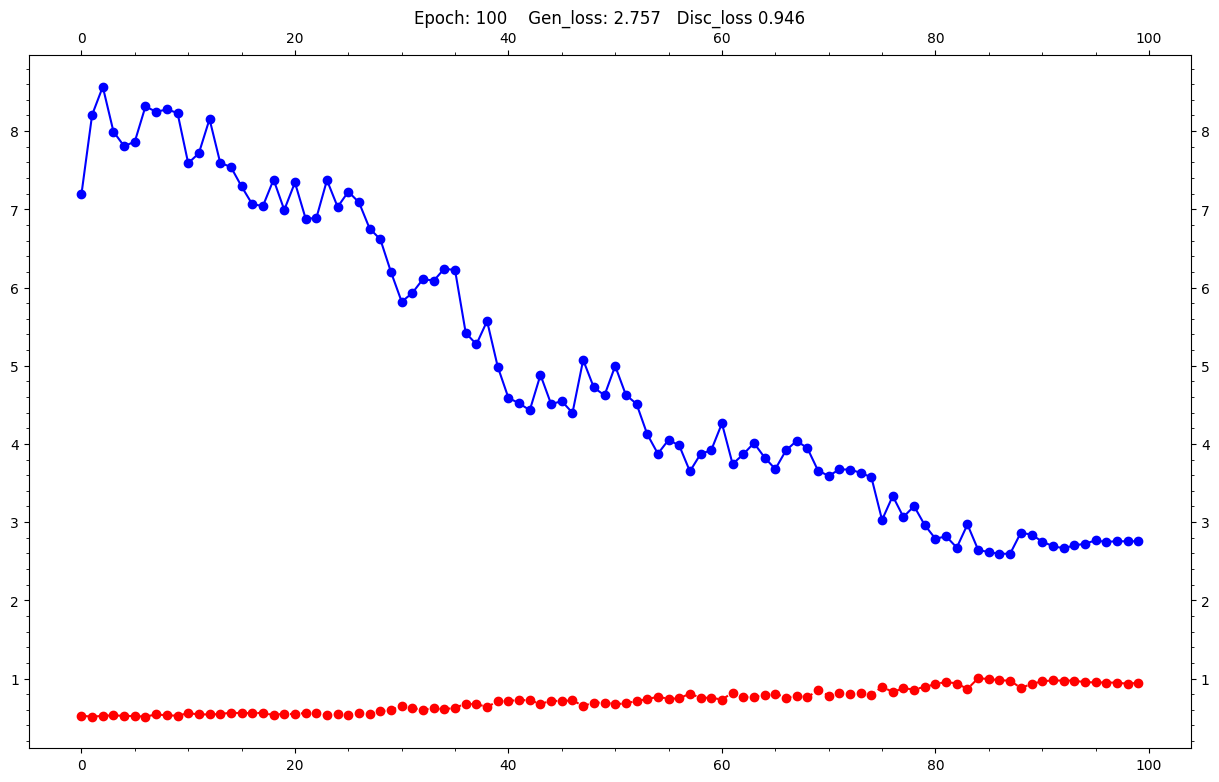

In [32]:
# takes some time
GAN_training(gen, disc, 100, generator_train_prob=0.5)

## **Predictions on generated data and validation dataset**

In [19]:
def check_model(gen, disc):
    rv_n = norm()
    gen.cpu().eval() # when you don't want to "train" model, but just use it
    disc.cpu().eval()
    plt.figure(figsize=(8, 6))

    random_vecs = gen(torch.tensor(rv_n.rvs(size=(valid_dataset.shape[0], noise_size))).float())
    #plt.xlim(0.1, 0.3)
    #plt.ylim(0.8, 1.0)
    prob, clss = disc(random_vecs)
    plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

    prob, clss = disc(valid_dataset) # check on the validation dataset
    plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

In [21]:
disc = Discriminator()
gen = Generator()

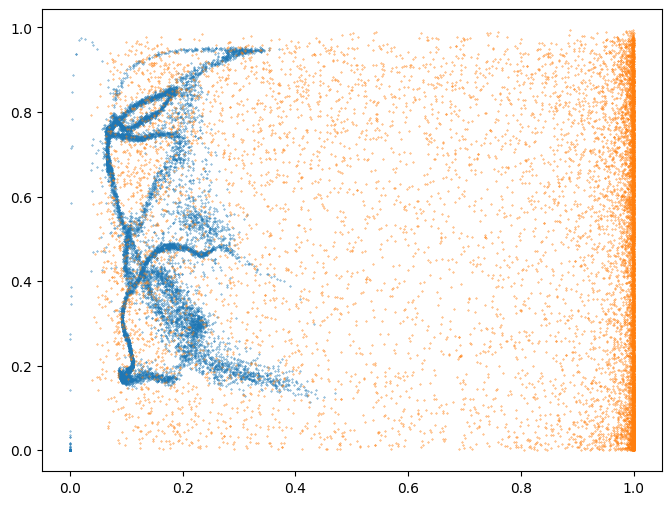

In [23]:
disc.load_state_dict(torch.load("/content/SGAN/models/disc_60_0.8.pt"))
gen.load_state_dict(torch.load("/content/SGAN/models/gen_60_0.8.pt"))

check_model(gen, disc)

Here we can see that training ratio 0.8 vs 0.2 for generator and discriminator, respectively, with only 60 epochs is leading to the interesting results such as limited generative ability of Generator.  

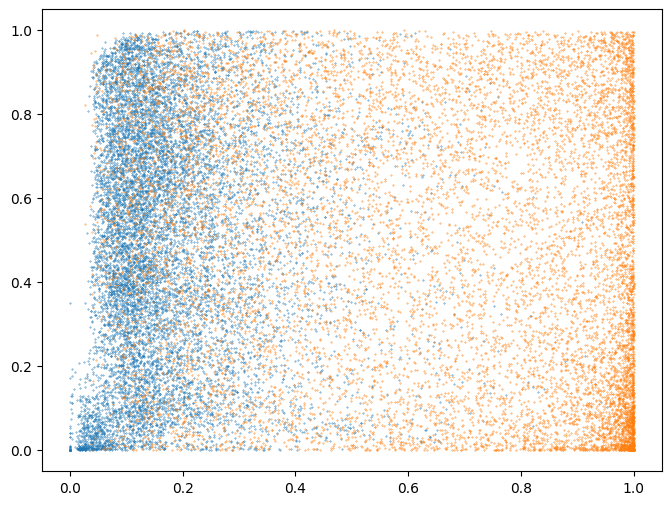

In [24]:
# Use already pretrained model
disc.load_state_dict(torch.load("/content/SGAN/models/disc_150_0.3.pt"))
gen.load_state_dict(torch.load("/content/SGAN/models/gen_150_0.3.pt"))

check_model(gen, disc)

# **Generation of new molecules**

In [25]:
rv_n = norm()

In [26]:
# we can use the already pretrained model to generate new molecules
disc = Discriminator()
disc.eval()
disc.load_state_dict(torch.load("/content/SGAN/models/disc_150_0.3.pt"))

gen = Generator()
gen.eval()
gen.load_state_dict(torch.load("/content/SGAN/models/gen_150_0.3.pt"))

<All keys matched successfully>

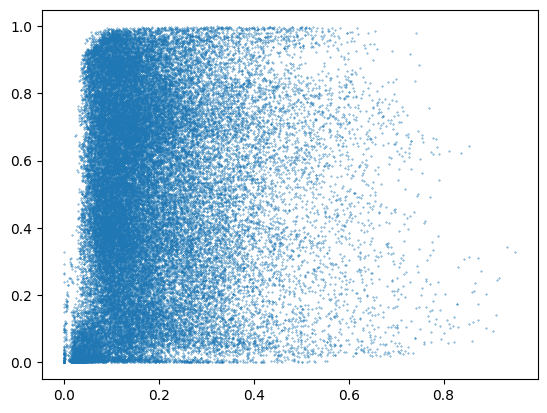

In [27]:
gen_vecs = gen(torch.tensor(rv_n.rvs(size=(50000, noise_size))).float())
prob, clss = disc(gen_vecs)

plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)